In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
from petitRADTRANS.physics import guillot_global
from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
import pandas as pd
import time
import os

In [3]:
true_transm = pd.read_hdf('../data/test_data_pinns.h5', key='transm')
atm_params = pd.read_hdf('../data/test_data_pinns.h5', key='params')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.set_num_threads(4)

atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      #'H2S',
                                      #'NH3',
                                      'Na_allard',
                                      'K_allard'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 5.0],
                      enable_pinn=False,
                      enable_rayleigh=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.set_num_threads(4)

/home/moon/ddahlb/miniconda3/envs/prt/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:104: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



## Plot example spectrum to test Rayleigh scattering PINN

In [5]:
atmosphere.rayleigh_model =  torch.load("../models/RayleighOnly_lxlynorm_lowBC01_4+2x64_400x50_3/TrainedModel/model.pkl", map_location=atmosphere.dev)

In [6]:
pressures = np.logspace(-6, 2, 100)

In [7]:
atmosphere.setup_opa_structure(pressures)

In [8]:
R_pl = 1.838*nc.r_jup_mean #1.838*nc.r_jup_mean
gravity = 1e1**2.8
P0 = 0.01

haze_factor = 1.0 # 70.

#gravity = 1e1**2.45
#kappa_IR = 0.04
#gamma = 0.05
#T_int = 200.
#T_equ = 730.
#temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

#temperature = 1030. * np.ones_like(pressures)
temperature = 1200. * np.ones_like(pressures)


#pressures2 = np.genfromtxt('PTprofile.csv', delimiter=',')[1:,1] * 1e-5
#temperature = np.genfromtxt('PTprofile.csv', delimiter=',')[1:,2]

MMWs = {}
MMWs['H2'] = 2 * 1.008
MMWs['He'] = 4.0026
MMWs['H2O_HITEMP'] = 2 * 1.008 + 15.999
MMWs['CO_all_iso_HITEMP'] = 12.011 + 15.999
MMWs['CO2'] = 12.011 + 2 * 15.999
MMWs['CH4'] = 12.011 + 4 * 1.008
MMWs['Na_allard'] = 22.99
MMWs['K_allard'] = 39.098

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature) # default: 0.74
mass_fractions['He'] = 0.24 * np.ones_like(temperature)  # default: 0.24
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)  # default: 0.001
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)  # default: 0.01
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)  # default: 0.00001
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)  # default: 0.000001
mass_fractions['Na_allard'] = 0.0000 * np.ones_like(temperature) # default: 0.00001
mass_fractions['K_allard'] = 0.00000 * np.ones_like(temperature) # default: 0.000001

#COs = 0.31 * np.ones_like(pressures)
#FeHs = 2.18 * np.ones_like(pressures)

#mass_fractions = interpol_abundances(COs, FeHs, temperature, pressures)

#mass_fractions['H2O_HITEMP'] = mass_fractions.pop('H2O')
#mass_fractions['CO_all_iso_HITEMP'] = mass_fractions.pop('CO')
#mass_fractions['Na_allard'] = mass_fractions.pop('Na') #* 1e1
#mass_fractions['K_allard'] = mass_fractions.pop('K') #* 1e1

#MMW = mass_fractions['MMW']

MMW = 2.33 * np.ones_like(temperature)

genAlpha = False
if genAlpha:
    msa = torch.tensor(np.array([np.linspace(-18.0,-6.0,100), np.linspace(6/2,10/2,100)]).swapaxes(0,1))
    std_rad = (np.sqrt(49.5**2 - (np.arange(100)-49.5)**2) / 49.5 * 0.05)
    std_rad[0] = 1.0
    std_rad[-1] = 1.0
    msr = torch.tensor(np.array([np.linspace(1.0,-1.0,100),std_rad]).swapaxes(0,1))
    print(msa.shape, msr.shape)
    atmosphere.mean_std_alpha = msa
    atmosphere.mean_std_radii = msr
# atmosphere.mean_std_alpha = torch.cat([torch.linspace(-18.0, -6.0, 100, dtype=torch.float32).unsqueeze(1), torch.linspace(4.5, 4.5, 100, dtype=torch.float32).unsqueeze(1)], dim=1).to(atmosphere.dev)

def get_details(atm_params):
    
    R_pl = atm_params['R_pl']*nc.r_jup_mean
    log_g = atm_params['log(g)'] # (SI units)
    gravity = 10**log_g * 100.0 # (SI to cgs!)
    P0 = 0.01 # pressure at R_pl

    temperature = atm_params['T'] * np.ones_like(pressures)

    vol_fractions = {}
    vol_fractions['H2O_HITEMP'] = (10.0**atm_params['log(H2O)'])
    vol_fractions['CO_all_iso_HITEMP'] = (10.0**atm_params['log(CO)'])
    vol_fractions['CO2'] = (10.0**atm_params['log(CO2)'])
    vol_fractions['CH4'] = (10.0**atm_params['log(CH4)'])

    rest_vol = 1.0
    for vol_frac in vol_fractions.values():
        rest_vol -=  vol_frac
    
    vol_fractions['He'] = rest_vol * atm_params['He/H2']
    vol_fractions['H2'] = rest_vol * (1.0 - atm_params['He/H2'])

    MMW = 0.0 * np.ones_like(pressures)
    for name, frac in vol_fractions.items():
        MMW += frac * MMWs[name]

    mass_fractions = {}
    for name, frac in vol_fractions.items():
        mass_fractions[name] = frac * MMWs[name] / MMW

    mass_fractions['Na_allard'] = 0.0
    mass_fractions['K_allard'] = 0.0
    
    # calculate transmission spectrum
    atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

    return atmosphere.transmission, atmosphere.alphas, atmosphere.radius_hse

def calc_MMW(atm_params):

    vol_fractions = {}
    vol_fractions['H2O_HITEMP'] = (10.0**atm_params['log(H2O)'])
    vol_fractions['CO_all_iso_HITEMP'] = (10.0**atm_params['log(CO)'])
    vol_fractions['CO2'] = (10.0**atm_params['log(CO2)'])
    vol_fractions['CH4'] = (10.0**atm_params['log(CH4)'])

    rest_vol = 1.0
    for vol_frac in vol_fractions.values():
        rest_vol -=  vol_frac
    
    vol_fractions['He'] = rest_vol * atm_params['He/H2']
    vol_fractions['H2'] = rest_vol * (1.0 - atm_params['He/H2'])

    MMW = 0.0 * np.ones_like(pressures)
    for name, frac in vol_fractions.items():
        MMW += frac * MMWs[name]

    return MMW

def calc_mass_fractions(vol_fractions):

    MMW = 0.0 * np.ones_like(pressures)
    for name, frac in vol_fractions.items():
        MMW += frac * MMWs[name]

    mass_fractions = {}
    for name, frac in vol_fractions.items():
        mass_fractions[name] = frac * MMWs[name] / MMW

    return MMW, mass_fractions

#volume_fractions = {}
#volume_fractions['H2'] = 0.74 * np.ones_like(temperature) # default: 0.74
#volume_fractions['He'] = 0.24 * np.ones_like(temperature)  # default: 0.24
#volume_fractions['H2O_HITEMP'] = 10**(-1.37) * np.ones_like(temperature)  # default: 0.001
#volume_fractions['CO_all_iso_HITEMP'] = 0.0 * np.ones_like(temperature)  # default: 0.01
#volume_fractions['CO2'] = 0.0000 * np.ones_like(temperature)  # default: 0.00001
#volume_fractions['CH4'] = 0.000 * np.ones_like(temperature)  # default: 0.000001
#volume_fractions['Na_allard'] = 10**(-3.7) * np.ones_like(temperature) # default: 0.00001
#volume_fractions['K_allard'] = 10**(-4.9) * np.ones_like(temperature) # default: 0.000001

#MMW, mass_fractions = calc_mass_fractions(volume_fractions)

print(MMW[0])
for name, frac in mass_fractions.items():
    print(name, frac[0])

2.33
H2 0.74
He 0.24
H2O_HITEMP 0.001
CO_all_iso_HITEMP 0.01
CO2 1e-05
CH4 1e-06
Na_allard 0.0
K_allard 0.0


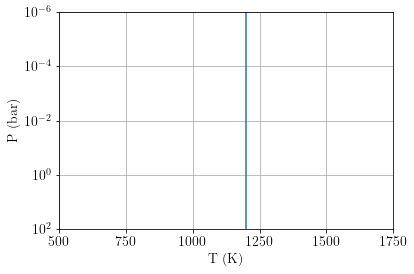

1200.0


<Figure size 432x288 with 0 Axes>

In [9]:
plt.plot(temperature, pressures)
#plt.plot(temperature, radius_tprofile/nc.r_jup_mean)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlim([500, 1750])
plt.xticks(np.linspace(500,1750,6))
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.grid()
plt.show()
plt.clf()
print(temperature[0])

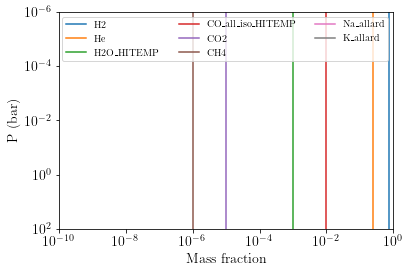

<Figure size 432x288 with 0 Axes>

In [10]:
plt.yscale('log')
plt.xscale('log')
plt.ylim([100,1e-6])
plt.xlim([1e-10, 1])

for species in mass_fractions.keys():
    if species not in ['MMW', 'nabla_ad']:#, 'NH3']:
        plt.plot(mass_fractions[species], pressures, label = species)

plt.legend(loc='best', ncol=3)
plt.xlabel('Mass fraction')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

In [11]:
#temperature = np.ones_like(pressures) * temperature[0]

#ind = 21
extra_specs = 3
if extra_specs > 1:
    mu_max = np.linspace(0.05,0.15,extra_specs)
    mu_max = (mu_max  - 0.5*0.3) / (0.5*0.3)
else:
    mu_max = np.array([0.0])

rayleigh_transm = []
rayleigh_final_transm = []
rayleigh_transm_rad = []

for i in range(extra_specs):
    atmosphere.enable_rayleigh = True
    atmosphere.rayleigh_on = 1
    atmosphere.incident_angle = mu_max[i]
    start = time.time()
    # pinn_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
    atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0, haze_factor=haze_factor)
    end = time.time()
    print(end-start)
    rayleigh_transm.append(atmosphere.transmission)
    rayleigh_final_transm.append(atmosphere.final_transm)
    rayleigh_transm_rad.append(atmosphere.transm_rad)

atmosphere.enable_rayleigh = True
atmosphere.rayleigh_on = 0
start = time.time()
# pinn_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0, haze_factor=haze_factor)
end = time.time()
print(end-start)
pinn_transm = atmosphere.transmission
pinn_final_transm = atmosphere.final_transm
pinn_transm_rad = atmosphere.transm_rad

atmosphere.enable_rayleigh = False
start = time.time()
# prt_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0, haze_factor=haze_factor)
end = time.time()
print(end-start)
prt_transm, alphas, radius_hse = atmosphere.transmission, atmosphere.alphas, atmosphere.radius_hse
prt_final_transm = atmosphere.final_transm
prt_transm_rad = atmosphere.transm_rad

1.6849312782287598
1.741685152053833
1.7872066497802734
1.7356626987457275
1.582282543182373


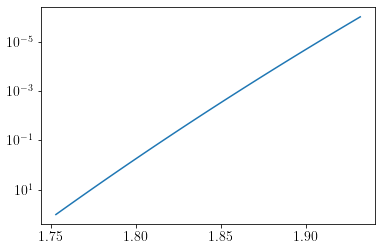

In [12]:
plt.plot(radius_hse/nc.r_jup_mean, pressures)
plt.gca().invert_yaxis()
plt.yscale('log')

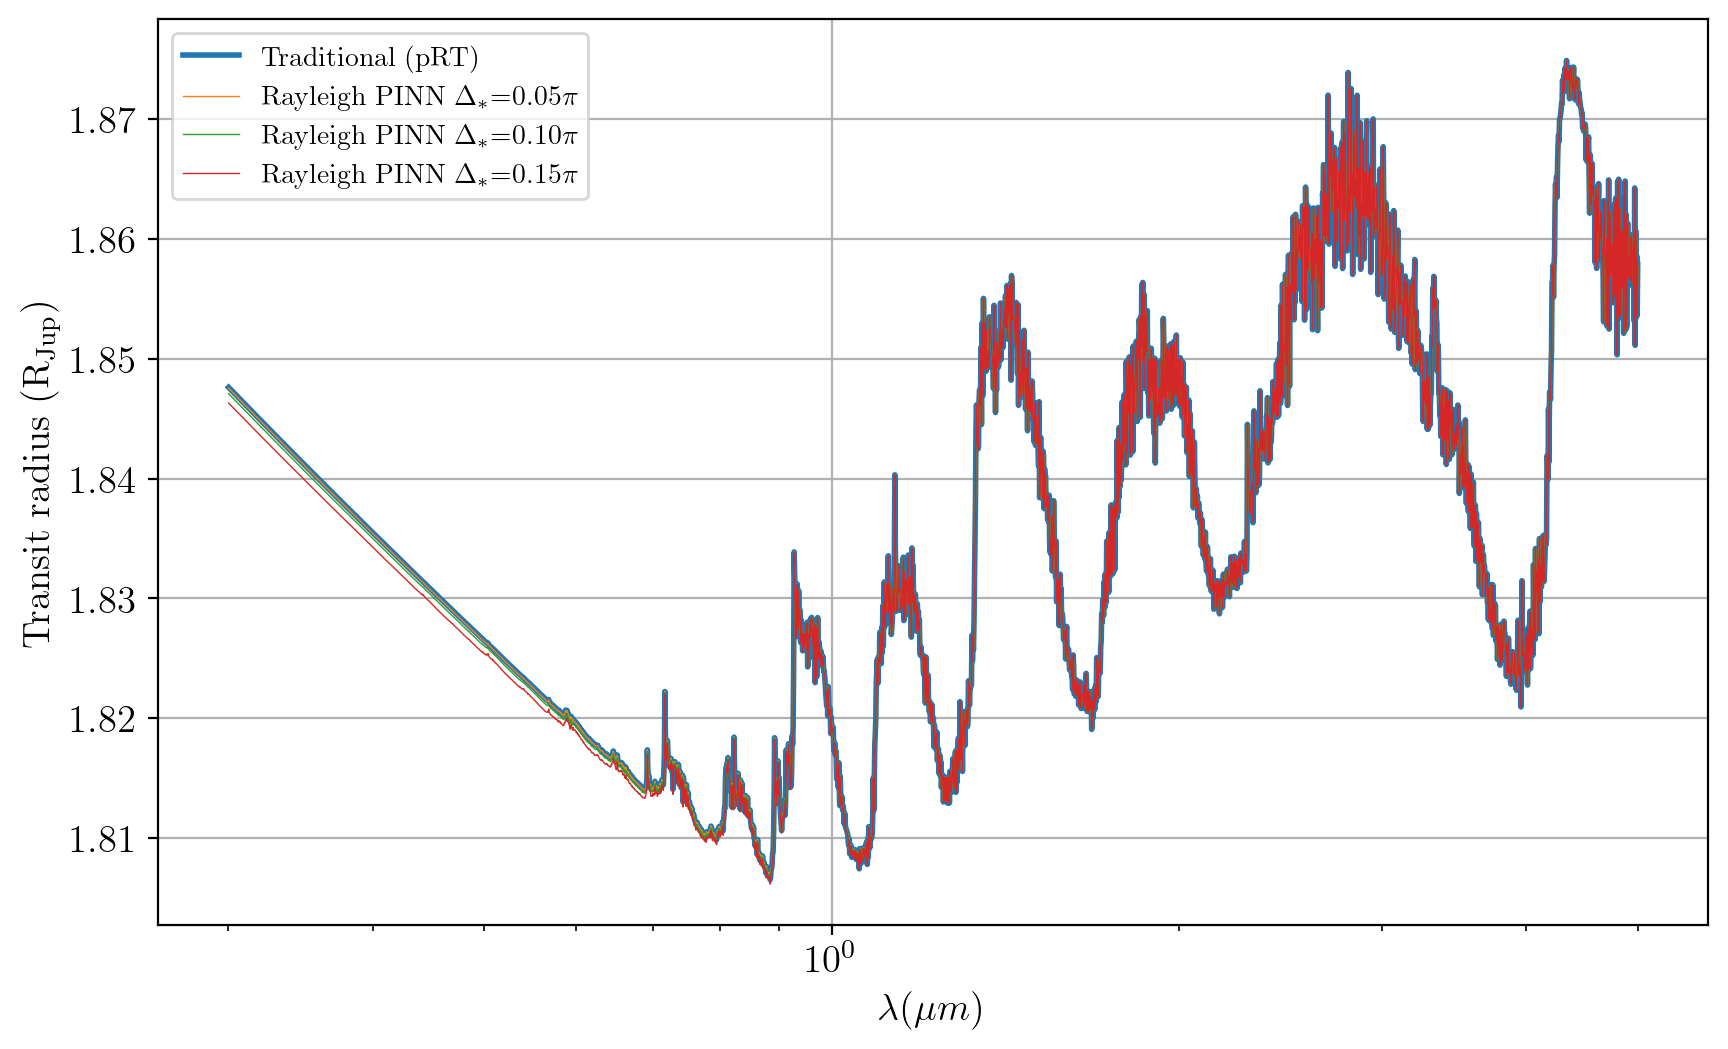

<Figure size 2000x1200 with 0 Axes>

In [13]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 200

plt.plot(nc.c/atmosphere.freq/1e-4, prt_transm_rad/nc.r_jup_mean, label='Traditional (pRT)', linewidth=2.0)
#plt.plot(nc.c/atmosphere.freq/1e-4, pinn_transm_rad/nc.r_jup_mean, label='Rayleigh PINN w/o scattering', linewidth=1.0)
for i in range(extra_specs):
    plt.plot(nc.c/atmosphere.freq/1e-4, rayleigh_transm_rad[i]/nc.r_jup_mean, label=f'Rayleigh PINN $\Delta_*$={(mu_max[i] * 0.5*0.3) + (0.5*0.3):.2f}$\pi$', linewidth=0.5)

plt.xscale('log')
#plt.xlim(0.3, 0.8)
#plt.ylim(1.0015, 1.01)
plt.xlabel(r'$\lambda (\mu m)$')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend()
plt.grid()
plt.show()
plt.clf()

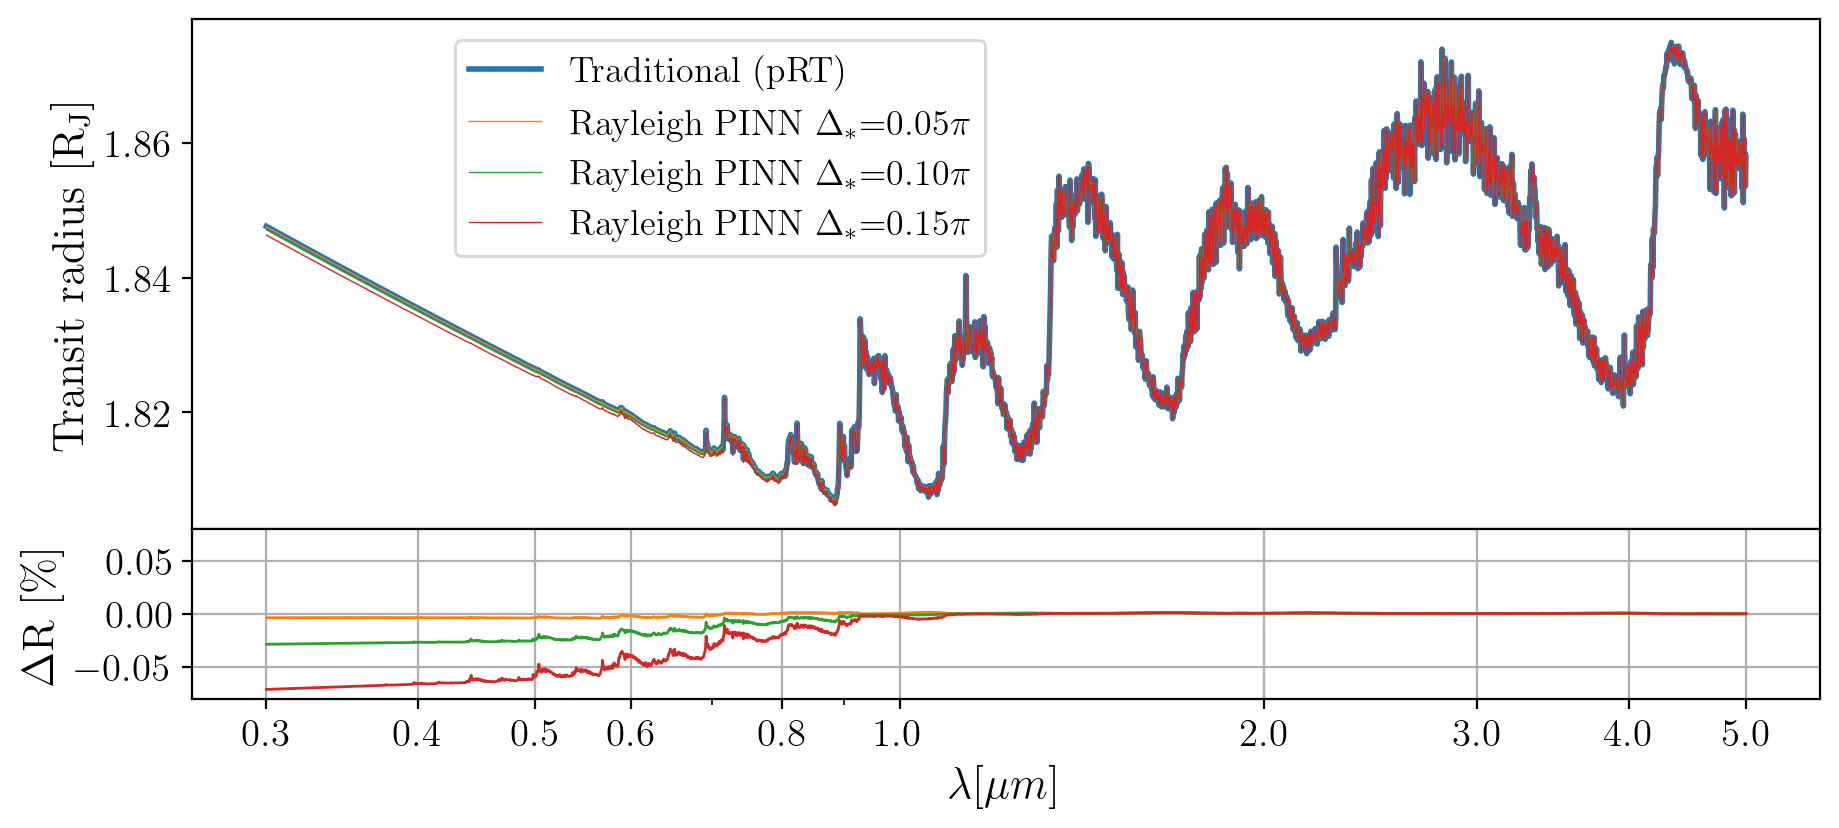

[4 3 2 1 0]


<Figure size 2000x1200 with 0 Axes>

In [24]:
fig, ax = plt.subplots(2,1, figsize=(10.5,4.5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

ax[0].plot(nc.c/atmosphere.freq/1e-4, prt_transm_rad/nc.r_jup_mean, label='Traditional (pRT)', linewidth=2.0)
#ax[0].plot(nc.c/atmosphere.freq/1e-4, pinn_transm_rad/nc.r_jup_mean, label='Rayleigh PINN w/o scattering', linewidth=1.0)
for i in range(extra_specs):
    ax[0].plot(nc.c/atmosphere.freq/1e-4, rayleigh_transm_rad[i]/nc.r_jup_mean, label=f'Rayleigh PINN $\Delta_*$={(mu_max[i] * 0.5*0.3) + (0.5*0.3):.2f}$\pi$', linewidth=0.5)

ax[0].set_xscale('log')
#ax[0].set_xlabel('Wavelength (microns)', fontsize=16)
ax[0].set_ylabel(r'Transit radius [$\rm R_{J}$]', fontsize=16)
ax[0].legend(loc='lower left', bbox_to_anchor=(0.15,0.5), fontsize=13)

#ax[0].hlines(atmosphere.radius_hse/nc.r_jup_mean, xmin=(nc.c/atmosphere.freq/1e-4).min(), xmax=(nc.c/atmosphere.freq/1e-4).max(),
#            color='black', linewidth=0.1)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(extra_specs):
    error = rayleigh_transm_rad[i] - prt_transm_rad
    rel_error = error/prt_transm_rad
    #max_diff = prt_transm_rad.max() - prt_transm_rad.min()
    #ax[1].plot(nc.c/atmosphere.freq/1e-4, error/nc.r_jup_mean, linewidth=1.0, color=default_colors[i+1])
    ax[1].plot(nc.c/atmosphere.freq/1e-4, 100*rel_error, linewidth=1.0, color=default_colors[i+1])

#ax[1].set_ylabel(r'$\Delta$R [$\rm R_{J}$]', fontsize=16)
#ax[1].set_ylim((-1.5e-3, 1.5e-3))
#ax[1].set_yticks((-1e-3,0,1e-3))
ax[1].set_ylabel(r'$\Delta$R [\%]', fontsize=16)
ax[1].set_ylim((-0.08, 0.08))
#ax[1].set_yticks((-1e-3,0,1e-3))

ax[1].set_xlabel(r'$\lambda [\mu m]$', fontsize=16)
xticks = np.concatenate((np.round(np.linspace(0.3,0.9,7), decimals=1), np.round(np.linspace(1,5,5), decimals=0)))
ax[1].set_xticks(xticks)
xticks[[4,6]] = np.nan
ax[1].set_xticklabels(xticks)

plt.grid()
plt.subplots_adjust(hspace=.0)
#plt.savefig('../images/ExampleSpec_ScaPINN.png', dpi=200)
plt.show()
plt.clf()

print(np.argsort(abs(error), axis=0)[-5:])

#rel_error = error/max_diff*100
#print(np.sqrt(np.mean(rel_error**2)))

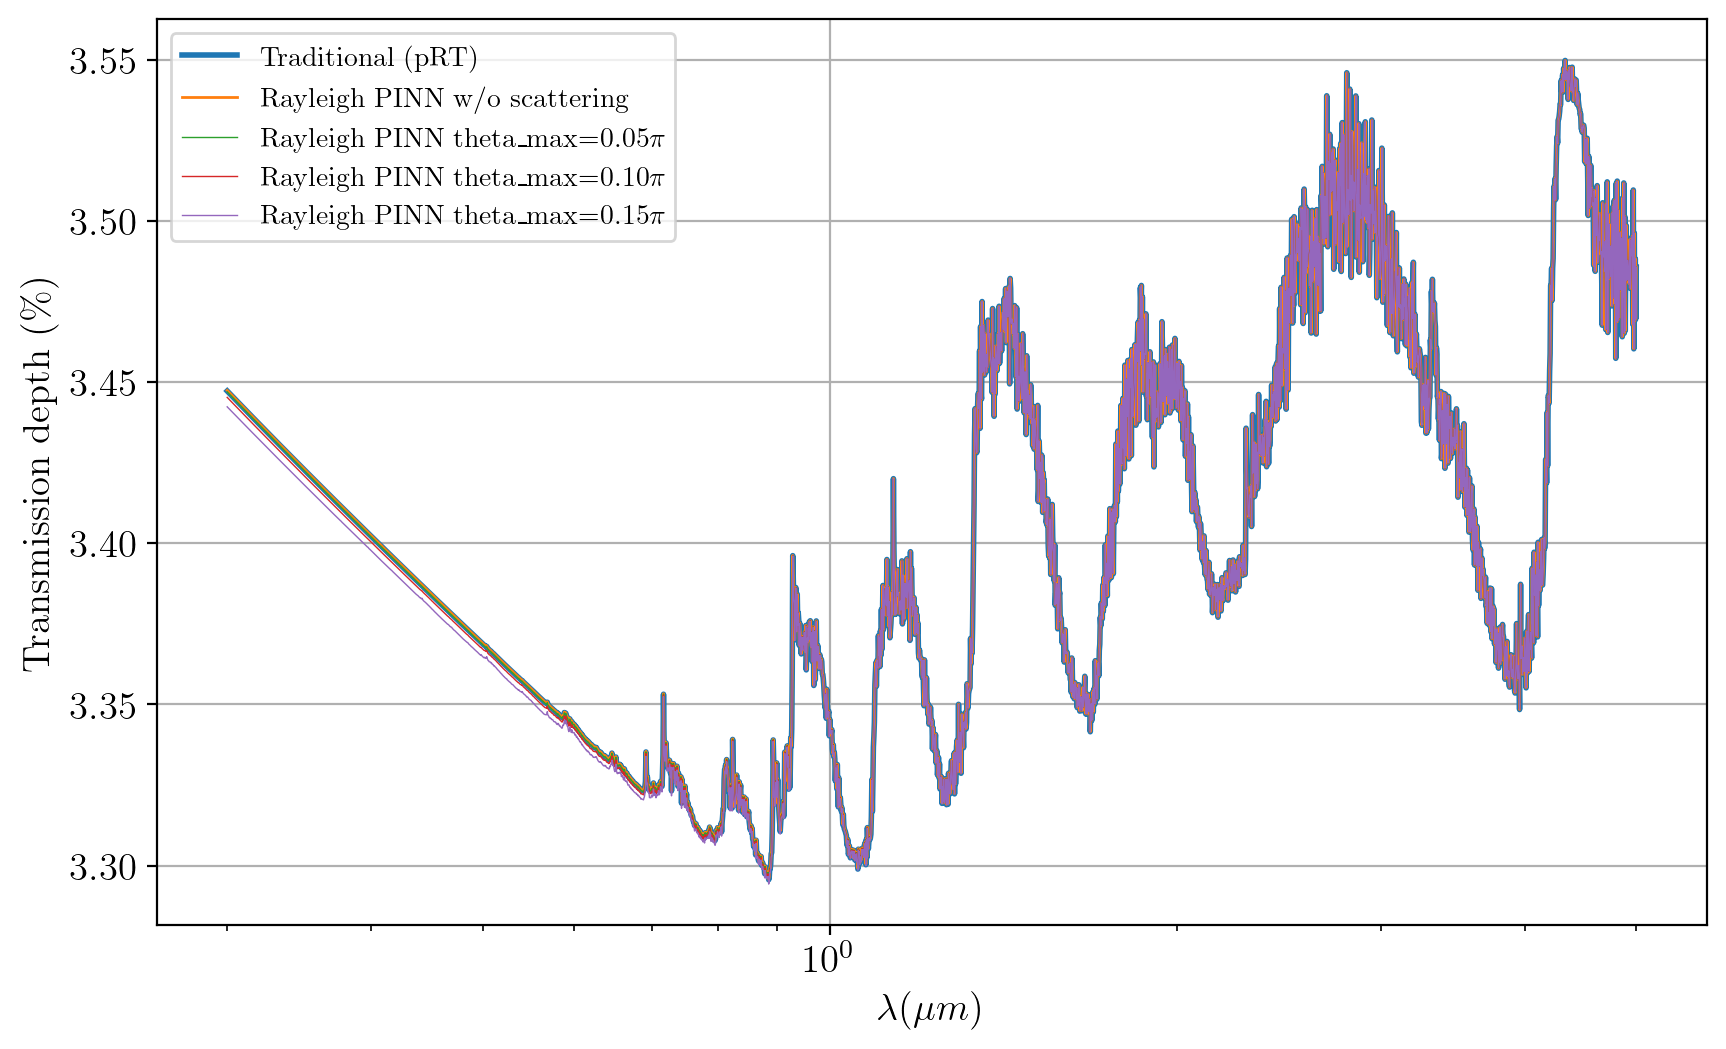

<Figure size 2000x1200 with 0 Axes>

In [15]:
R_sun = 1.0 * nc.r_sun
sq = 2
if sq == 1:
    factor = 1
elif sq == 2:
    factor = 100

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 200

plt.plot(nc.c/atmosphere.freq/1e-4, factor*(prt_transm_rad/R_sun)**sq, label='Traditional (pRT)', linewidth=2.0)
plt.plot(nc.c/atmosphere.freq/1e-4, factor*(pinn_transm_rad/R_sun)**sq, label='Rayleigh PINN w/o scattering', linewidth=1.0)
for i in range(extra_specs):
    plt.plot(nc.c/atmosphere.freq/1e-4, factor*(rayleigh_transm_rad[i]/R_sun)**sq, label=f'Rayleigh PINN theta_max={(mu_max[i] * 0.5*0.3) + (0.5*0.3):.2f}$\pi$', linewidth=0.5)

plt.xscale('log')
#plt.xlim(0.29, 5.1)
#plt.ylim(0.142, 0.152)
plt.xlabel(r'$\lambda (\mu m)$')
if sq == 2:
    plt.ylabel('Transmission depth (\%)')
elif sq == 1:
    plt.ylabel(r'Transit depth $(R_P / R_*)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

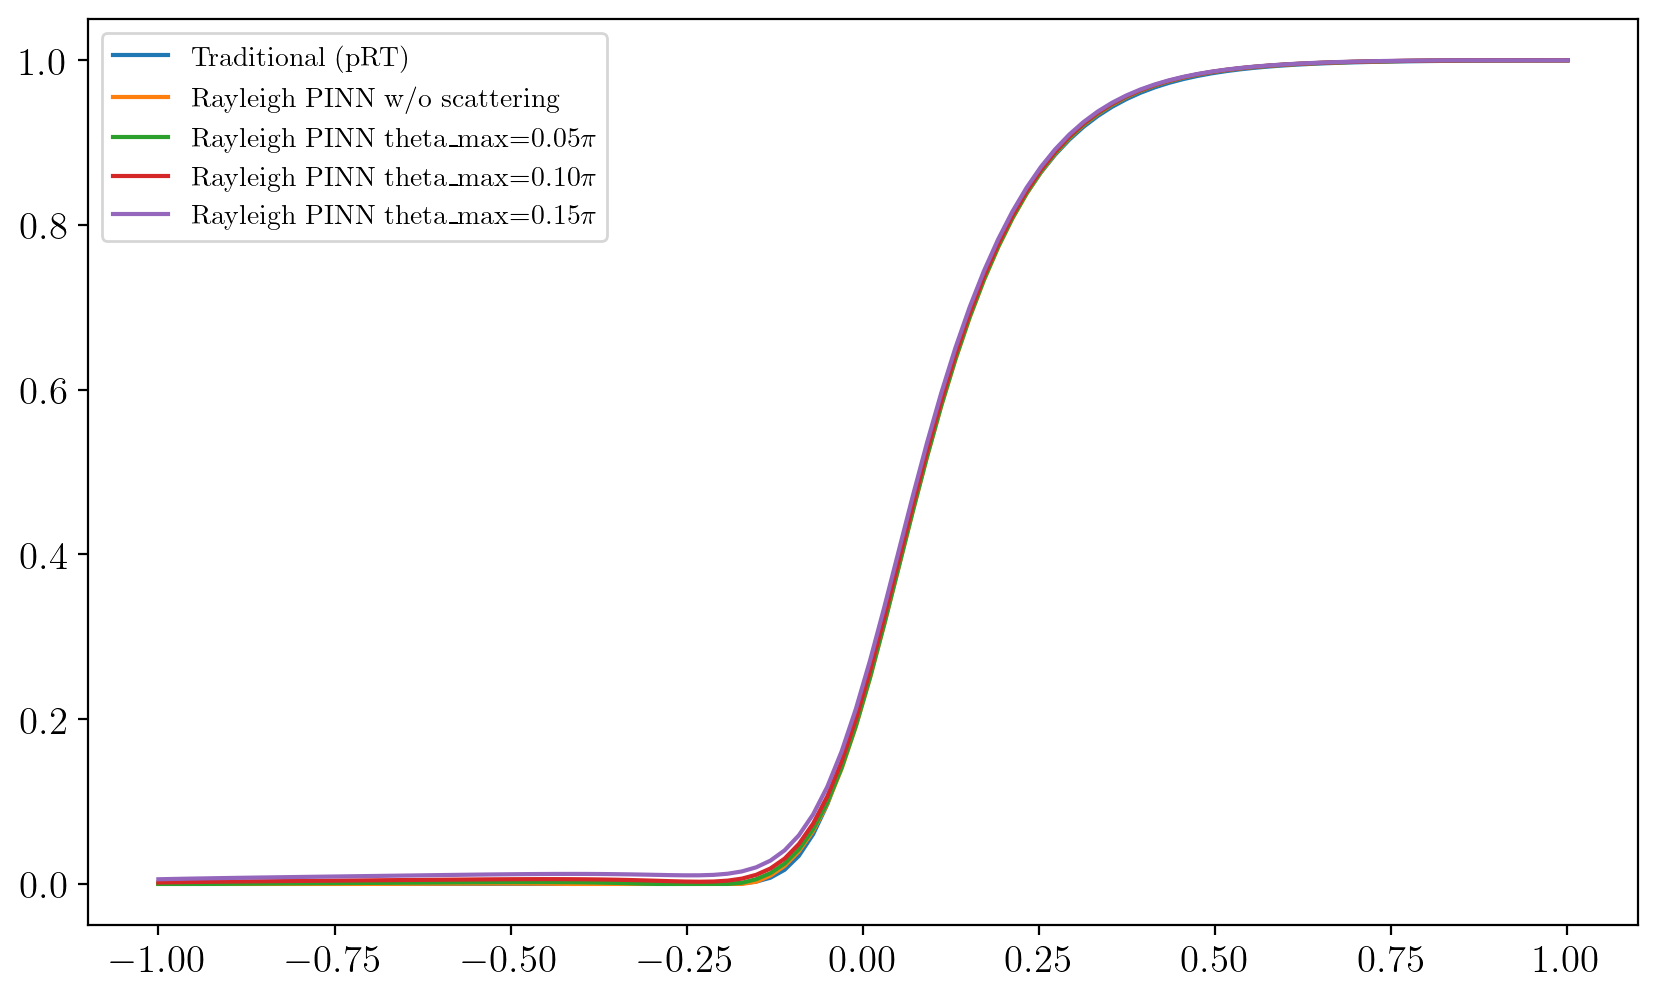

In [20]:
plt.rcParams['figure.figsize'] = (10, 6)
x = np.linspace(1,-1,100)

plt.plot(x, prt_transm[0,0,0,:], label='Traditional (pRT)')
plt.plot(x, pinn_transm[0,0,0,:], label='Rayleigh PINN w/o scattering')
for i in range(extra_specs):
    plt.plot(x, rayleigh_transm[i][0,0,0,:], label=f'Rayleigh PINN theta_max={(mu_max[i] * 0.5*0.3) + (0.5*0.3):.2f}$\pi$')
    
plt.legend()
plt.show()

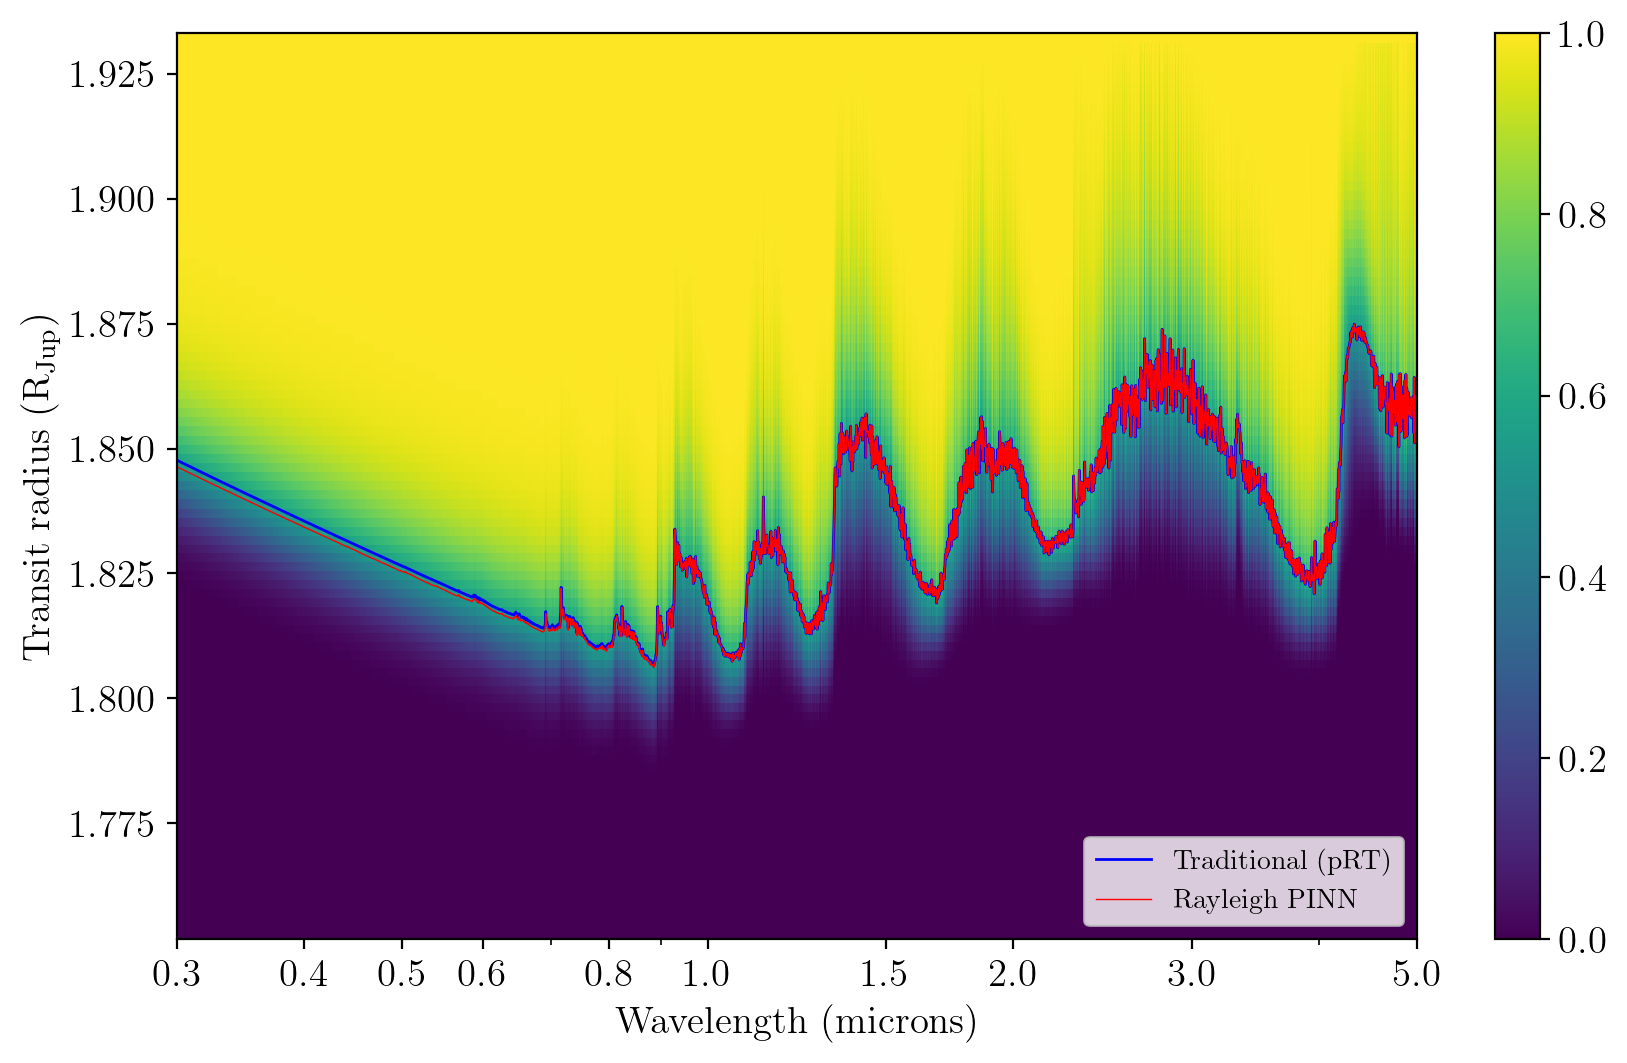

In [24]:
pcm = plt.pcolormesh(nc.c/atmosphere.freq/1e-4, radius_hse/nc.r_jup_mean, rayleigh_final_transm[0], shading='nearest', vmin=0.0, vmax=1.0)
plt.plot(nc.c/atmosphere.freq/1e-4, prt_transm_rad/nc.r_jup_mean, label='Traditional (pRT)', linewidth=1.0, c='blue')
plt.plot(nc.c/atmosphere.freq/1e-4, rayleigh_transm_rad[-1]/nc.r_jup_mean, label='Rayleigh PINN', linewidth=0.5, c='red')

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.xticks([0.3,0.4,0.5,0.6,0.8,1.0,1.5,2.0,3.0,5.0])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.colorbar(pcm)
plt.legend(loc='lower right')
#plt.savefig('ExampleSpectrum_Rayleigh_Transm.png', dpi=200)
plt.show()
#plt.clf()